In [1]:
import torch
from math import sqrt
from sszd.optimizer import SSZD
from sszd.direction_matrices import QRDirections, RandomCoordinate

import matplotlib.pyplot as plt

In [19]:
from typing import Any


class LeastSquares:

    def __init__(self, n, d, L, mu, x_star = None, dtype = torch.float32, seed = 121314) -> None:
        assert x_star is None or x_star.shape[0] == d
        self.generator = torch.Generator()
        self.generator.manual_seed(seed)
        self.n = n
        self.d = d
        A = torch.randn((n, d), generator=self.generator, dtype=dtype)
        U, s, V = torch.linalg.svd(A)
        s = torch.linspace(sqrt(L), sqrt(mu), s.shape[0], dtype=dtype)
        self.A = U @ torch.diag(s) @ V

        self.y = self.A @ x_star
    
    def __call__(self, x, z = None) -> Any:
        if z is None:
            return (self.A @ x - self.y).norm(p=2).square()
        return (self.A[z, :] @ x - self.y[z]).norm(p=2).square()

In [43]:
d = 100
n = 100
num_directions = [1, 5, 25, 50, 100]#, 30, 40, 45, 50]#, 25, 40, 50]#, 95, 99, 100]
dtype=torch.float64

L, mu = 10.0, 1.0

target = LeastSquares(n = n, d = d, L=L, mu=mu, x_star=torch.zeros(d, dtype=dtype), dtype=dtype)

x0 = torch.full((d,), 1.0, dtype=dtype)



In [44]:

results = []
labels = []
T = 25000
gen_sampler = torch.Generator()

def sample_z():
    return torch.randint(0, high=n, size=(1,), generator=gen_sampler)

for l in num_directions:
    alpha = lambda k :  0.99  * (1/L) * (l/d) * (1/((k + 1)**(1/2 + 1e-10)))
    h = lambda k :  1e-5 / sqrt(k + 1)# * (1/sqrt(k + 1)) #if 0.1* (1/(k + 1)**2) > 1e-7 else 1e-7
    T_opt = T // (l + 1) if T % l ==0 else T // (l + 1) + 1
    opt = SSZD(target = target, alpha = alpha, h = h, P = QRDirections(d = d, l = l, dtype=dtype))
    ris = opt.optimize(x0=x0, sample_z=sample_z, T = T_opt, verbose=True, return_trace=True)
    fvalues = []
    for fv in ris['fun_values']:
        fvalues += [fv for _ in range(l + 1)]
    results.append(fvalues)
    labels.append("l = {}".format(l))


[SSZD l = 5]:  71%|████▉  | 2965/4166 [00:02<00:01, 1179.41it/s, k=2974, f(x_k)=423, |g|=46.3]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

[SSZD l = 100]: 100%|███████████| 247/247 [00:03<00:00, 75.73it/s, k=247, f(x_k)=236, |g|=8.4]


Text(38.097222222222214, 0.5, '$f(x_k)$')

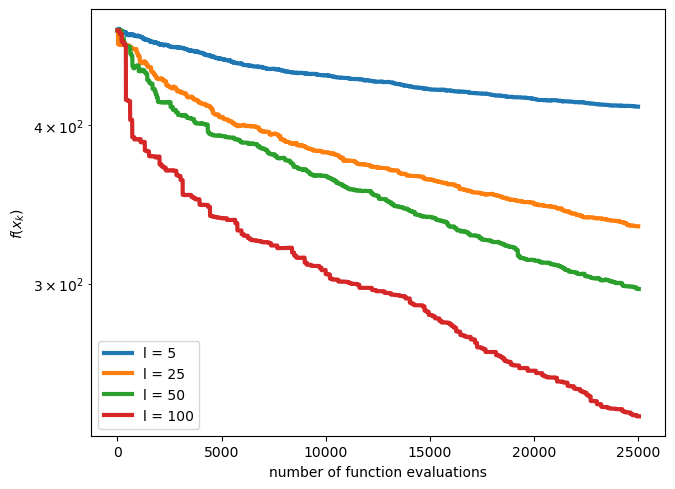

In [45]:
fig, ax = plt.subplots()

for (label, result) in zip(labels, results):
    ax.plot(range(len(result)), result, '-', label=label, lw=3)

fig.tight_layout()
ax.set_yscale("log")
ax.legend(loc='best')
ax.set_xlabel("number of function evaluations")
ax.set_ylabel("$f(x_k)$")
